In [2]:
# Step 1: Import Required Libraries
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report, accuracy_score
from sklearn.metrics import confusion_matrix, roc_curve, auc,precision_recall_curve
import joblib
import matplotlib.pyplot as plt
import seaborn as sns


# Step 2: Load Data
df = pd.read_csv("adult 3.csv")

In [3]:
df

,age,workclass,fnlwgt,education,educational-num,marital-status,occupation,relationship,race,gender,capital-gain,capital-loss,hours-per-week,native-country,income
0,25,Private,226802,11th,7,Never-married,Machine-op-inspct,Own-child,Black,Male,0,0,40,United-States,<=50K
1,38,Private,89814,HS-grad,9,Married-civ-spouse,Farming-fishing,Husband,White,Male,0,0,50,United-States,<=50K
2,28,Local-gov,336951,Assoc-acdm,12,Married-civ-spouse,Protective-serv,Husband,White,Male,0,0,40,United-States,>50K
3,44,Private,160323,Some-college,10,Married-civ-spouse,Machine-op-inspct,Husband,Black,Male,7688,0,40,United-States,>50K
4,18,?,103497,Some-college,10,Never-married,?,Own-child,White,Female,0,0,30,United-States,<=50K
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
48837,27,Private,257302,Assoc-acdm,12,Married-civ-spouse,Tech-support,Wife,White,Female,0,0,38,United-States,<=50K
48838,40,Private,154374,HS-grad,9,Married-civ-spouse,Machine-op-inspct,Husband,White,Male,0,0,40,United-States,>50K
48839,58,Private,151910,HS-grad,9,Widowed,Adm-clerical,Unmarried,White,Female,0,0,40,United-States,<=50K
48840,22,Private,201490,HS-grad,9,Never-married,Adm-clerical,Own-child,White,Male,0,0,20,United-States,<=50K


In [4]:
# Step 3: Replace '?' with NaN and drop missing
df.replace("?", np.nan, inplace=True)
df.dropna(inplace=True)

# Step 4: Drop irrelevant column
df.drop(columns=['fnlwgt'], inplace=True)


In [5]:
df

,age,workclass,education,educational-num,marital-status,occupation,relationship,race,gender,capital-gain,capital-loss,hours-per-week,native-country,income
0,25,Private,11th,7,Never-married,Machine-op-inspct,Own-child,Black,Male,0,0,40,United-States,<=50K
1,38,Private,HS-grad,9,Married-civ-spouse,Farming-fishing,Husband,White,Male,0,0,50,United-States,<=50K
2,28,Local-gov,Assoc-acdm,12,Married-civ-spouse,Protective-serv,Husband,White,Male,0,0,40,United-States,>50K
3,44,Private,Some-college,10,Married-civ-spouse,Machine-op-inspct,Husband,Black,Male,7688,0,40,United-States,>50K
5,34,Private,10th,6,Never-married,Other-service,Not-in-family,White,Male,0,0,30,United-States,<=50K
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
48837,27,Private,Assoc-acdm,12,Married-civ-spouse,Tech-support,Wife,White,Female,0,0,38,United-States,<=50K
48838,40,Private,HS-grad,9,Married-civ-spouse,Machine-op-inspct,Husband,White,Male,0,0,40,United-States,>50K
48839,58,Private,HS-grad,9,Widowed,Adm-clerical,Unmarried,White,Female,0,0,40,United-States,<=50K
48840,22,Private,HS-grad,9,Never-married,Adm-clerical,Own-child,White,Male,0,0,20,United-States,<=50K


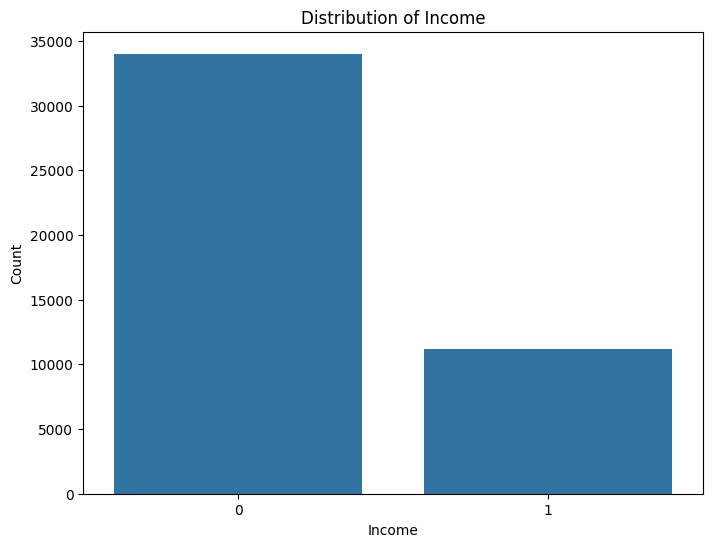

In [25]:
# Income distribution
plt.figure(figsize=(8, 6))
sns.countplot(x='income', data=df)
plt.title('Distribution of Income')
plt.xlabel('Income')
plt.ylabel('Count')
plt.show()

In [6]:
# Step 5: Normalize country names (group rare ones into "Other")
top_countries = df['native-country'].value_counts().nlargest(10).index
df['native-country'] = df['native-country'].apply(lambda x: x if x in top_countries else 'Other')

In [7]:
# Step 6: Strip whitespace from string columns
cat_cols = df.select_dtypes(include='object').columns
df[cat_cols] = df[cat_cols].apply(lambda x: x.str.strip())

In [8]:

# Step 7: Apply log1p transformation on skewed columns
df['capital-gain'] = df['capital-gain'].apply(lambda x: np.log1p(x))
df['capital-loss'] = df['capital-loss'].apply(lambda x: np.log1p(x))

In [9]:
# Step 8: Cap outliers using 1st and 99th percentiles
def cap_outliers(df, col):
    lower = df[col].quantile(0.01)
    upper = df[col].quantile(0.99)
    df[col] = df[col].clip(lower, upper)

for col in ['age', 'capital-gain', 'capital-loss', 'hours-per-week']:
    cap_outliers(df, col)

In [10]:

# Step 9: Rename columns for ease
df.columns = df.columns.str.replace('-', '_').str.lower()

In [11]:
# Step 10: Label encode categorical features
label_encoders = {}
for col in df.select_dtypes(include='category').columns.tolist() + df.select_dtypes(include='object').columns.tolist():
    if col != 'income':
        le = LabelEncoder()
        df[col] = le.fit_transform(df[col])
        label_encoders[col] = le

In [12]:
# Encode target
target_encoder = LabelEncoder()
df['income'] = target_encoder.fit_transform(df['income'])  # <=50K = 0, >50K = 1


In [13]:

# Step 11: Split dataset
X = df.drop('income', axis=1)
# Save feature order
joblib.dump(X.columns.tolist(), "feature_columns.pkl")
y = df['income']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)


In [14]:

# Step 12: Scale features
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)


In [15]:

# Step 13: Train model
model = LogisticRegression(max_iter=1000)
model.fit(X_train_scaled, y_train)


LogisticRegression(max_iter=1000)

In [16]:

# Step 14: Evaluate model
y_pred = model.predict(X_test_scaled)
print("✅ Accuracy:", accuracy_score(y_test, y_pred))
print("\n📊 Classification Report:\n", classification_report(y_test, y_pred))


✅ Accuracy: 0.8170259812050856

📊 Classification Report:
               precision    recall  f1-score   support

           0       0.84      0.94      0.89      6842
           1       0.69      0.44      0.54      2203

    accuracy                           0.82      9045
   macro avg       0.77      0.69      0.71      9045
weighted avg       0.80      0.82      0.80      9045



In [17]:

# Step 15: Save model and tools
joblib.dump(model, "salary_prediction_model.pkl")
joblib.dump(scaler, "scaler.pkl")
joblib.dump(label_encoders, "label_encoders.pkl")
joblib.dump(target_encoder, "target_encoder.pkl")

['target_encoder.pkl']

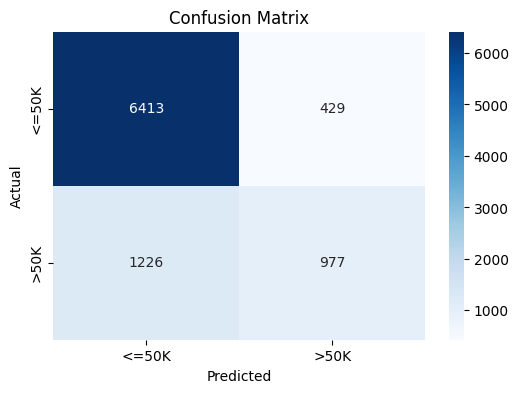

In [18]:
# Confusion Matrix
cm = confusion_matrix(y_test, y_pred)
plt.figure(figsize=(6, 4))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=target_encoder.classes_, yticklabels=target_encoder.classes_)
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Confusion Matrix')
plt.show()

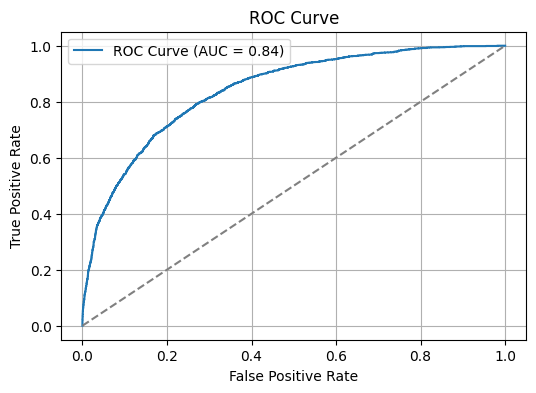

In [19]:
# ROC Curve
y_proba = model.predict_proba(X_test_scaled)[:, 1]
fpr, tpr, _ = roc_curve(y_test, y_proba)
roc_auc = auc(fpr, tpr)

plt.figure(figsize=(6, 4))
plt.plot(fpr, tpr, label=f'ROC Curve (AUC = {roc_auc:.2f})')
plt.plot([0, 1], [0, 1], linestyle='--', color='gray')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve')
plt.legend()
plt.grid(True)
plt.show()

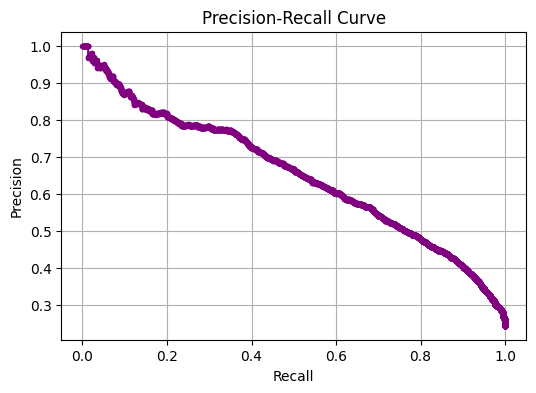

In [20]:
# Precision-Recall Curve
precision, recall, _ = precision_recall_curve(y_test, y_proba)
plt.figure(figsize=(6, 4))
plt.plot(recall, precision, marker='.', color='purple')
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.title('Precision-Recall Curve')
plt.grid(True)
plt.show()

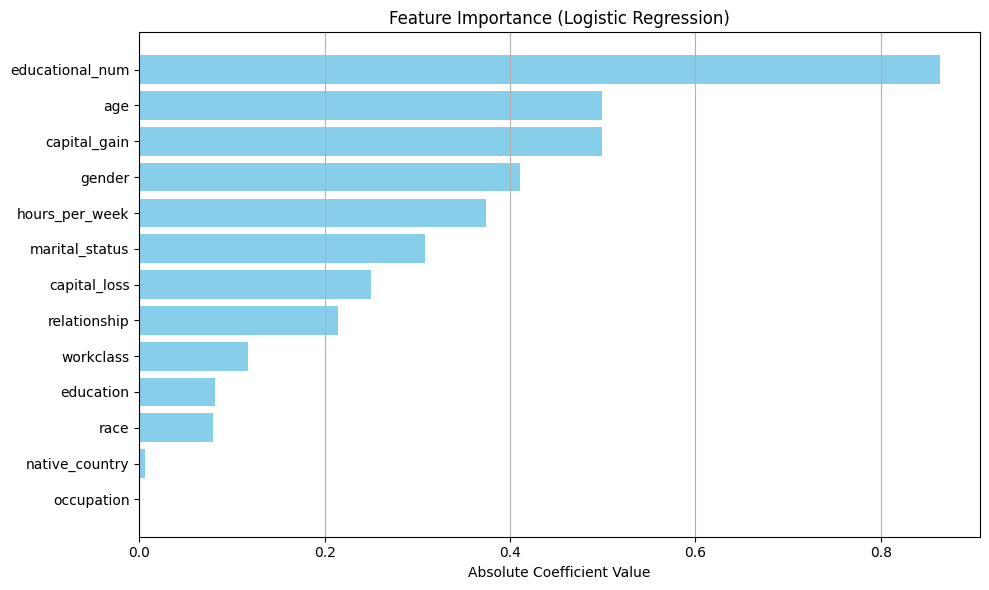

In [21]:
import numpy as np
import matplotlib.pyplot as plt

# Get feature names and model coefficients
feature_names = X.columns
coefficients = model.coef_[0]

# Create a DataFrame for easier visualization
importance_df = pd.DataFrame({
    'Feature': feature_names,
    'Importance': np.abs(coefficients)
}).sort_values(by='Importance', ascending=False)

# Plot
plt.figure(figsize=(10, 6))
plt.barh(importance_df['Feature'], importance_df['Importance'], color='skyblue')
plt.xlabel('Absolute Coefficient Value')
plt.title('Feature Importance (Logistic Regression)')
plt.gca().invert_yaxis()
plt.tight_layout()
plt.grid(True, axis='x')
plt.show()


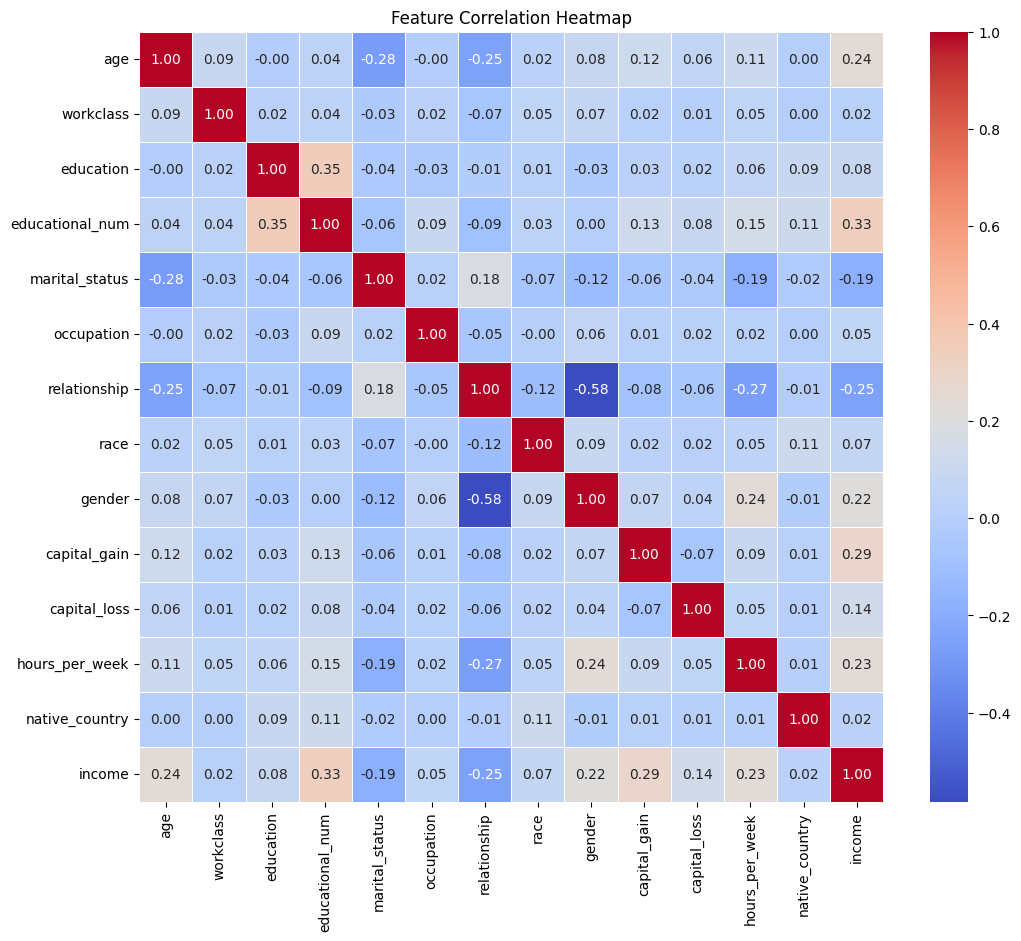

In [22]:
# prompt: Feature correlation heatmap

import matplotlib.pyplot as plt
# Compute the correlation matrix
correlation_matrix = df.corr()

# Plot the heatmap
plt.figure(figsize=(12, 10))
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', fmt=".2f", linewidths=.5)
plt.title('Feature Correlation Heatmap')
plt.show()

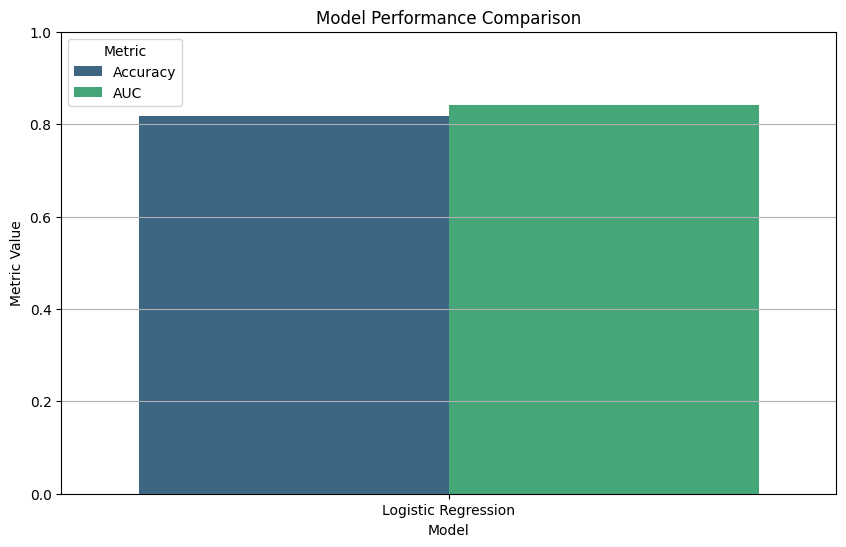

In [23]:
# prompt: Model performance comparison chart

import pandas as pd
import matplotlib.pyplot as plt
# Assuming you have a dictionary or list of model performance metrics
# Example structure: {'Model_Name': {'Metric_Name': value, ...}}
# Replace this with your actual model training and evaluation results
model_performance = {
    'Logistic Regression': {
        'Accuracy': accuracy_score(y_test, y_pred),
        'AUC': roc_auc
    }
    # Add other models and their metrics here
    # e.g., 'Random Forest': {'Accuracy': rf_accuracy, 'AUC': rf_auc}
    # 'SVM': {'Accuracy': svm_accuracy, 'AUC': svm_auc}
}

# Convert the dictionary to a DataFrame for easier plotting
performance_df = pd.DataFrame(model_performance).T.reset_index()
performance_df.rename(columns={'index': 'Model'}, inplace=True)

# Melt the DataFrame to have metrics as a column for bar plotting
performance_melted = performance_df.melt(id_vars='Model', var_name='Metric', value_name='Value')

# Plotting the performance comparison
plt.figure(figsize=(10, 6))
sns.barplot(x='Model', y='Value', hue='Metric', data=performance_melted, palette='viridis')
plt.ylabel('Metric Value')
plt.title('Model Performance Comparison')
plt.ylim(0, 1) # Set y-axis limits appropriate for metrics like Accuracy and AUC
plt.grid(axis='y')
plt.show()